# MRtrix: Part 2 
## Constrained Spherical Deconvolution and Tissue estimation


This notebook is the second in a series on Diffusion Analysis using MRtrix and builds upon the preprocessed data generated in **MRtrix: Part 1 - Preprocessing**. The data necessary for this example will be downloaded from OSF. 


####
**Author:** Monika Doerig

**Date:** 5 June 2025

### Citation and Resources:

#### Tools included in this workflow
__MRtrix3:__ 
- Tournier, J.-D.; Smith, R. E.; Raffelt, D.; Tabbara, R.; Dhollander, T.; Pietsch, M.; Christiaens, D.; Jeurissen, B.; Yeh, C.-H. & Connelly, A. MRtrix3: A fast, flexible and open software framework for medical image processing and visualisation. NeuroImage, 2019, 202, 116137. [https://doi.org/10.1016/j.neuroimage.2019.116137](https://doi.org/10.1016/j.neuroimage.2019.116137)
- For more details: [https://www.mrtrix.org/](https://www.mrtrix.org/)


__DIPY:__
- Garyfallidis, E., Brett, M., Amirbekian, B., Rokem, A., van der Walt, S., Descoteaux, M., Nimmo-Smith, I., & Dipy Contributors (2014). Dipy, a library for the analysis of diffusion MRI data. Frontiers in neuroinformatics, 8, 8. [https://doi.org/10.3389/fninf.2014.00008](https://doi.org/10.3389/fninf.2014.00008)

#### Educational Resources

__Andy's Brain Book:__

- This MRtrix example is based on the [Diffusion Analysis with MRtrix](https://andysbrainbook.readthedocs.io/en/latest/MRtrix/MRtrix_Introduction.html#) chapter from Andy’s Brain Book (Jahn, 2022. [doi:10.5281/zenodo.5879293](https://zenodo.org/records/5879294))

__Tutorial on Neurodesk:__ 
- [Publishing and Accessing Open Data on OSF with ```osfclient``` on Neurodesk](https://neurodesk.org/edu/tutorials/open_data/osfclient.html)


#### Dataset
__Original Data from OpenNeuro:__
- Hannelore Aerts and Daniele Marinazzo (2018). BTC_preop. [OpenNeuro Dataset ds001226](https://openneuro.org/datasets/ds001226/versions/00001)

__Preprocessed Diffusion Data from OSF:__
- Dörig, M. (2024, November 19). Diffusion MRI Analysis with MRtrix: An Interactive Three-Part Series on Neurodesk. Retrieved from [OSF](https://osf.io/y2dq4/)



### Import Python Libraries

In [2]:
%%capture
! pip install numpy==1.26.4 vtk==9.4.0 fury==0.11.0 dipy==1.9.0 nibabel==5.3.2 ipyniivue==2.3.2

In [1]:
import os
import subprocess
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tempfile
from ipyniivue import NiiVue
from IPython.display import display, Markdown, Image
from ipywidgets import RadioButtons, VBox, HBox, Dropdown, Output
from dipy.data import default_sphere
from dipy.core.gradients import gradient_table
from dipy.io.image import load_nifti
from dipy.reconst.csdeconv import auto_response_ssst
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
from dipy.viz import window, actor
from dipy.sims.voxel import single_tensor_odf
from dipy.direction import peaks_from_model

## Introduction

In this notebook, we focus on Constrained Spherical Deconvolution (CSD) to estimate Fiber Orientation Distributions (FODs) for the different tissue types. Additionally, FODs are normalized and tissue boundaries are derived from the anatomical image. The boundaries will be the starting point for generating streamlines in subsequent analyses. 

In the next part of this series, we will address registration and streamline fitting, advancing toward tractography.

### Load modules

In [7]:
import module
await module.load('mrtrix3/3.0.4')
await module.load('fsl/6.0.7.4')
await module.list()

['mrtrix3/3.0.4', 'fsl/6.0.7.4']

## Downloading the preprocessed data from MRtrix Part 1

In [8]:
! osf -p y2dq4 fetch preprocessed/mask.mif MRtrix_preprocessed/mask.mif
! osf -p y2dq4 fetch preprocessed/sub-02_den_preproc_unbiased.mif MRtrix_preprocessed/sub-02_den_preproc_unbiased.mif
! osf -p y2dq4 fetch preprocessed/sub-CON02_ses-preop_T1w.nii.gz MRtrix_preprocessed/sub-CON02_ses-preop_T1w.nii.gz
! osf -p y2dq4 fetch preprocessed/sub-02_AP.bval MRtrix_preprocessed/sub-02_AP.bval
! osf -p y2dq4 fetch preprocessed/sub-02_AP.bvec MRtrix_preprocessed/sub-02_AP.bvec

100%|██████████████████████████████████| 80.0k/80.0k [00:00<00:00, 40.5Mbytes/s]
100%|████████████████████████████████████| 226M/226M [00:07<00:00, 28.5Mbytes/s]
100%|██████████████████████████████████| 8.31M/8.31M [00:00<00:00, 59.8Mbytes/s]
100%|██████████████████████████████████████| 476/476 [00:00<00:00, 3.82Mbytes/s]
100%|██████████████████████████████████| 2.77k/2.77k [00:00<00:00, 15.6Mbytes/s]


Try typing one of the commands from the library, such as ```mrconvert```. If MRtrix has been installed correctly, you should see the help page printed by default when no arguments are passed to the command:

In [9]:
! mrconvert | head -n 18

MRtrix 3.0.4                        mrconvert                        Mar 20 2024

     mrconvert: part of the MRtrix3 package

SYNOPSIS

     Perform conversion between different file types and optionally extract a
     subset of the input image

USAGE

     mrconvert [ options ] input output

        input        the input image.

        output       the output image.




## Constrained Spherical Deconvolution
In order to determine the orientation of diffusion within each voxel, we will create a basis function from the subject’s own data. By extracting the diffusion signal from representative grey matter, white matter, and cerebrospinal fluid voxels, we will build a model to estimate what the signal should look like in different orientations and when we apply different b-values. The concept is similar to using a hemodynamic response function (HRF) as a basis function for fMRI data: We have a canonical shape of what we believe the fMRI signal should look like in response to a single event, and then we modulate it to fit the observed data.

The response function is similar to the canonical HRF we use in fMRI studies. In this case, however, we’re estimating the response function for each tissue type. If you happened to collect your diffusion data with multiple b-values, then this approach in MRtrix is called multi-shell multi-tissue (MSMT).

### dwi2response

Unlike most fMRI studies which use a basis function that has been created beforehand, MRtrix will derive a basis function from the diffusion data; using an individual subject’s data is more precise and specific to that subject. The command ```dwi2response``` has several different algorithms that you can choose from, but for this tutorial we will use the “dhollander” algorithm:

In [10]:
! dwi2response dhollander MRtrix_preprocessed/sub-02_den_preproc_unbiased.mif wm.txt gm.txt csf.txt -voxels voxels.mif

dwi2response: 
dwi2response: Note that this script makes use of commands / algorithms that have relevant articles for citation. Please consult the help page (-help option) for more information.
dwi2response: 
dwi2response: Generated scratch directory: /home/jovyan/Git_repositories/example-notebooks/books/diffusion_imaging/dwi2response-tmp-KLMJ15/
dwi2response: Importing DWI data (/home/jovyan/Git_repositories/example-notebooks/books/diffusion_imaging/MRtrix_preprocessed/sub-02_den_preproc_unbiased.mif)...
dwi2response: Changing to scratch directory (/home/jovyan/Git_repositories/example-notebooks/books/diffusion_imaging/dwi2response-tmp-KLMJ15/)
dwi2response: Computing brain mask (dwi2mask)...
dwi2response: -------
dwi2response: 4 unique b-value(s) detected: 0,700,1200,2800 with 6,16,30,50 volumes
dwi2response: -------
dwi2response: Preparation:
dwi2response: * Eroding brain mask by 3 pass(es)...
dwi2response:   [ mask: 94895 -> 66960 ]
dwi2response: * Computing signal decay metric (SD

##### 
This command uses an algorithm to deconvolve the fiber orientation distributions (FODs) - in other words, it tries to decompose the diffusion signal into a set of smaller individual fiber orientations. You have several algorithms to choose from, but the most common are tournier and dhollander. The tournier algorithm is used for single-shell data and for a single tissue type (e.g., white matter). The dhollander algorithm can be used for either single- or multi-shell data, and for multiple tissue types. Estimating the FOD for each tissue type will later help us do anatomically constrained tractography.

The next argument specifies your input data, and the resulting response functions for the different tissue types. The order matters; you can call the output files whatever you want, but it makes the most sense to label them as some kind of variation on the phrases “white matter”, “grey matter”, and “cerebrospinal fluid” (here, labeled as “wm.txt”, “gm.txt”, and “csf.txt”). The last option, “-voxels”, specifies an output dataset that shows which voxels from the image were used to construct the basis functions for each tissue type. This dataset can be viewed by typing the following:

```javascript
mrview sub-02_den_preproc_unbiased.mif -overlay.load voxels.mif
```

We will visualize the voxels used to construct a basis function for each tissue type using **Matplotlib**. CSF voxels should be colored red, gray matter voxels green, and white matter voxels blue:

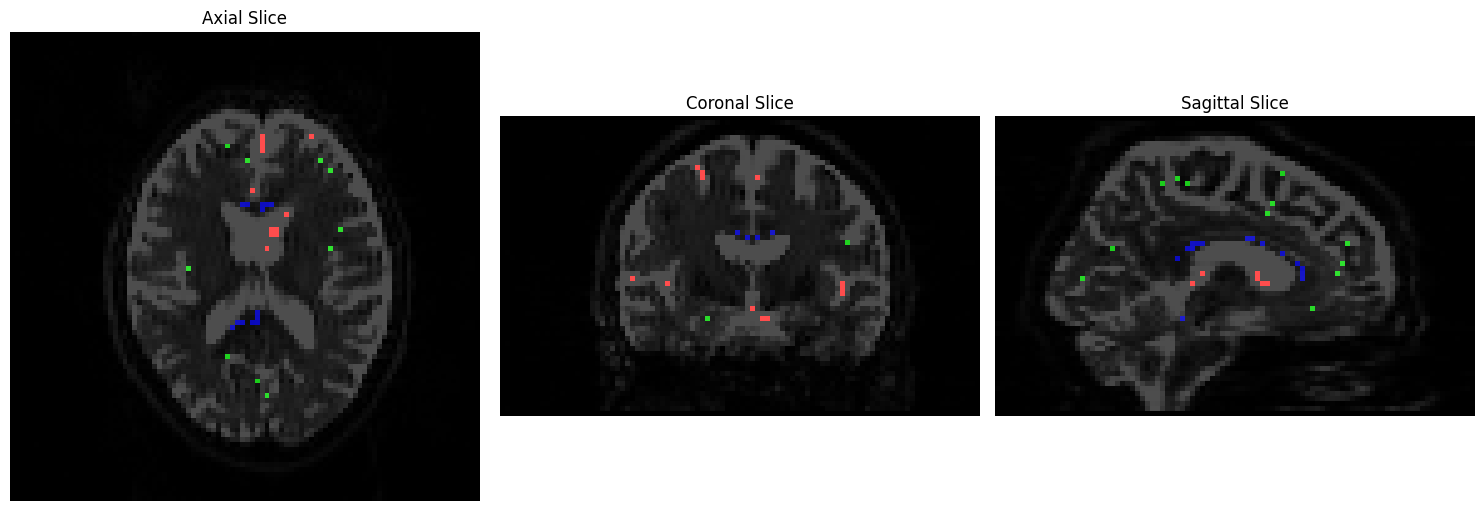

In [11]:
# Function to convert .mif files to temporary .nii.gz files
def convert_mif_to_nii(mif_file):
    with tempfile.NamedTemporaryFile(suffix=".nii.gz", delete=False) as temp_file:
        result = subprocess.run(["mrconvert", mif_file, temp_file.name, "-force"], capture_output=True, text=True)
        if result.returncode != 0:
            print(f"Error in mrconvert: {result.stderr}")
            exit()
        return temp_file.name

mif_file_path1 = './MRtrix_preprocessed/sub-02_den_preproc_unbiased.mif'
mif_file_path2 = 'voxels.mif'

# Convert both .mif files to temporary .nii.gz files
nii_file1 = convert_mif_to_nii(mif_file_path1)
nii_file2 = convert_mif_to_nii(mif_file_path2)

# Load the converted images
data1 = nib.load(nii_file1).get_fdata()
data2 = nib.load(nii_file2).get_fdata()

# Choose the middle slices 
slice_idx1 = data1.shape[2] // 2  # Axial slice 
slice_idx2 = data1.shape[1] // 2  # Coronal slice 
slice_idx3 = data1.shape[0] // 2  # Sagittal slice

# Prepare RGB overlay for tissue types 
rgb_overlay = np.zeros(data2.shape[:3] + (3,), dtype=np.float32)
rgb_overlay[..., 0] = data2[..., 0]  # Red for CSF
rgb_overlay[..., 1] = data2[..., 1]  # Green for GM
rgb_overlay[..., 2] = data2[..., 2]  # Blue for WM

# Plot the slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial slice
axes[0].imshow(np.rot90(data1[:, :, slice_idx1, 0]), cmap="Greys_r", vmin=0, vmax=700)
axes[0].imshow(np.rot90(rgb_overlay[:, :, slice_idx1]), alpha=0.7)
axes[0].axis("off")
axes[0].set_title('Axial Slice')

# Coronal slice
axes[1].imshow(np.rot90(data1[:, slice_idx2, :, 0]), cmap="Greys_r", vmin=0, vmax=700)
axes[1].imshow(np.rot90(rgb_overlay[:, slice_idx2, :]), alpha=0.7)
axes[1].axis("off")
axes[1].set_title('Coronal Slice')

# Sagittal slice
axes[2].imshow(np.rot90(data1[slice_idx3, :, :, 0]), cmap="Greys_r", vmin=0, vmax=700)
axes[2].imshow(np.rot90(rgb_overlay[slice_idx3, :, :]), alpha=0.7)
axes[2].axis("off")
axes[2].set_title('Sagittal Slice')

# Adjust layout and display
plt.tight_layout()
plt.show()

## Fiber Orientation Density (FOD)
We will now use the basis functions generated above to create Fiber Orientation Densities, or FODs. These are estimates of the amount of diffusion in each of three orthogonal directions. As described in the introductory chapter, these are analogous to the tensors that are used in traditional diffusion studies. However, MRtrix allows for the estimation of multiple crossing fibers within a single voxel, and can resolve the diffusion signal into multiple directions.

To do this, we will use the command ```dwi2fod``` to apply the basis functions to the diffusion data. The “-mask” option specifies which voxels we will use; this is simply to restrict our analysis to brain voxels and reduce the computing time. The “.mif” files specified after each basis function will output an FOD image for that tissue type:

In [ ]:
! dwi2fod msmt_csd MRtrix_preprocessed/sub-02_den_preproc_unbiased.mif -mask MRtrix_preprocessed/mask.mif wm.txt wmfod.mif gm.txt gmfod.mif csf.txt csffod.mif

dwi2fod: [100%] preloading data for "MRtrix_preprocessed/sub-02_den_preproc_unbiased.mif"[0K
dwi2fod: [ 63%] performing MSMT CSD (4 shells, 3 tissues)...

In order to view these FODs, we will combine them into a single image. The command ```mrconvert``` will extract the first image from the wmfod.mif file, which is the image with a b-value of 0. The output of this command is then used as the input into an ```mrcat``` command which combines the FOD images from all three tissue types into a single image that we will call “vf.mif”:

In [13]:
! mrconvert -coord 3 0 wmfod.mif - | mrcat csffod.mif gmfod.mif - vf.mif

mrconvert: [100%] copying from "wmfod.mif" to "/tmp/mrtrix-tmp-Mgr4TX.mif"[0K
mrcat: [100%] concatenating "csffod.mif"[0K
mrcat: [100%] concatenating "gmfod.mif"[0K
mrcat: [100%] concatenating "/tmp/mrtrix-tmp-Mgr4TX.mif"[0K


####
The white matter FODs can then be overlaid on this image, so that we can observe whether the white matter FODs do indeed fall within the white matter, and also whether they are along the orientations that we would expect. The command for mrview is: 
```javascript
mrview vf.mif -odf.load_sh wmfod.mif
```

####

Now, we will use the python libraries **DIPY** and **Matplotlib** to visualize white matter FODs of an axial slice. However, we will also need to reconstruct the fiber orientation distribution function (fODF) with DIPY in two steps:

- Estimation of the fiber response function
- Use the response function to reconstruct the fODF

#### Reconstruction with Constrained Spherical Deconvolution with DIPY

A straightforward method for estimating the fiber response function is to focus on regions of the brain known to contain single, coherent fiber populations. For instance, placing a region of interest (ROI) at the center of the brain can capture single fibers from the corpus callosum. The ```auto_response_ssst``` function computes the fractional anisotropy (FA) within a cuboidal ROI, defined by radii specified in roi_radii. It then derives the response function based on voxels with an FA value exceeding 0.7.

In [16]:
data_path = convert_mif_to_nii('sub-02_den_preproc_unbiased.mif')

# Load the data
data, affine = load_nifti(data_path) 

bvals_ap = np.loadtxt('sub-02_AP.bval')
bvecs_ap = np.loadtxt('sub-02_AP.bvec').T  # Make sure to transpose bvecs for correct shape

# Create the gradient table
gtab_ap = gradient_table(bvals_ap, bvecs_ap)

response, ratio = auto_response_ssst(gtab_ap, data, roi_radii=10, fa_thr=0.7)

To ensure the response function is accurate, we can visualize its orientation distribution function (ODF):

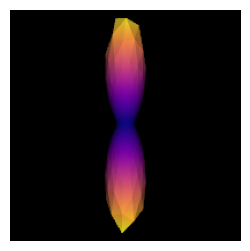

In [17]:
scene = window.Scene()
evals = response[0]
evecs = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]]).T

response_odf = single_tensor_odf(default_sphere.vertices, evals, evecs)
# transform our data from 1D to 4D
response_odf = response_odf[None, None, None, :]
response_actor = actor.odf_slicer(response_odf, sphere=default_sphere,
                                  colormap='plasma')
scene.add(response_actor)

csd_response = window.snapshot(
    scene, fname=os.path.join(os.getcwd(), 'csd_response.png'), size=(200, 200),
    offscreen=True)

fig, axes = plt.subplots(figsize=(3,3))
axes.imshow(csd_response, cmap="plasma")
axes.axis("off")
plt.show()

After estimating the response function, we can begin the deconvolution process by fitting the CSD model to the data.

100%|██████████| 900/900 [00:00<00:00, 3660.70it/s]


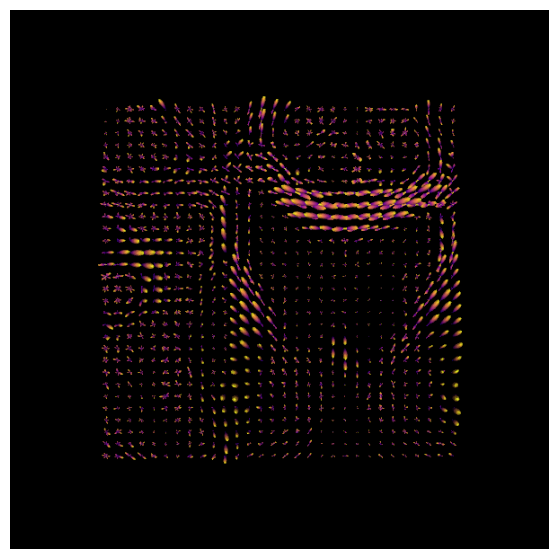

In [18]:
# Set up the scene for visualization
scene = window.Scene()

# Fit the CSD model to the data
csd_model = ConstrainedSphericalDeconvModel(gtab_ap, response)

# Fit on a smaller portion of the data (optional for faster computation)
data_small =  data[30:60, 40:70, 29:30]    
csd_fit = csd_model.fit(data_small) 
csd_odf = csd_fit.odf(default_sphere)

fodf_spheres = actor.odf_slicer(csd_odf, sphere=default_sphere, 
                              scale=0.9, norm=False, 
                              colormap='plasma')
scene.add(fodf_spheres)

csd_odfs = window.snapshot(
    scene, fname=os.path.join(os.getcwd(), 'csd_odfs.png'), size=(600, 600),
    offscreen=True)

fig, axes = plt.subplots(figsize=(7,7))
axes.imshow(csd_odfs, cmap="plasma")
axes.axis("off")
plt.show()

Using DIPY's ```peaks_from_model```, we can identify the peak directions (maxima) of the ODFs. We will then visualize the ODFs and their corresponding peaks in the same space.

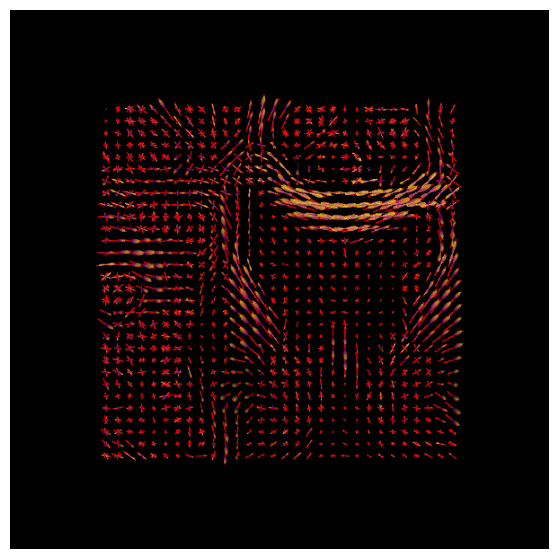

In [19]:
csd_peaks = peaks_from_model(model=csd_model,
                             data=data_small,
                             sphere=default_sphere,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True,
                             num_processes=10)

scene.clear()
fodf_peaks = actor.peak_slicer(csd_peaks.peak_dirs, peaks_values=csd_peaks.peak_values)
scene.add(fodf_peaks)

fodf_spheres.GetProperty().SetOpacity(0.6)
scene.add(fodf_spheres)

csd_both = window.snapshot(
    scene, fname=os.path.join(os.getcwd(), 'csd_both.png'), size=(600, 600),
    offscreen=True)

fig, axes = plt.subplots(figsize=(7,7))
axes.imshow(csd_both, cmap="plasma")
axes.axis("off")
plt.show()

## Normalization

In order to make the comparisons valid across subjects, we will need to normalize the FODs. This ensures that any differences we see are not due to intensity differences in the image, similar to how we correct for the size of the brain when comparing volumetric differences across subjects.

To normalize the data, we will use the ```mtnormalise``` command. This requires an input and output for each tissue type, as well as a mask to restrict the analysis to brain voxels:

In [20]:
! mtnormalise wmfod.mif wmfod_norm.mif gmfod.mif gmfod_norm.mif csffod.mif csffod_norm.mif -mask MRtrix_preprocessed/mask.mif

mtnormalise: [100%] performing log-domain intensity normalisation[0K


Now that we’ve correctly estimated the FODs for each tissue type, we are ready to begin laying down the foundation for our tractography analysis. The next step will be to determine the boundary between the grey matter and the white matter, which we will use as a starting point for our streamlines.

## Creating the Tissue Boundaries
We are almost ready to begin our streamline analysis, in which we will place seeds at random locations along the boundary between the grey matter and the white matter. A streamline will grow from each seed and trace a path from that seed region until it terminates in another region. Some of the streamlines will terminate in places that don’t make sense - for example, a streamline may terminate at the border of the ventricles. We will cull these “error” streamlines, and be left with a majority of streamlines that appear to connect distant grey matter regions.

To do this, we will first need to create a boundary between the grey matter and the white matter. The MRtrix command ```5ttgen``` will use FSL’s FAST, along with other commands, to segment the anatomical image into five tissue types:

    Grey Matter;

    Subcortical Grey Matter (such as the amygdala and basal ganglia);

    White Matter;

    Cerebrospinal Fluid; and

    Pathological Tissue.

Once we have segmented the brain into those tissue classes, we can then use the boundary as a mask to restrict where we will place our seeds.

### Converting the Anatomical Image

The anatomical image first needs to be converted to MRtrix format with ```mrconvert```.

In [21]:
! mrconvert MRtrix_preprocessed/sub-CON02_ses-preop_T1w.nii.gz T1.mif

mrconvert: [100%] uncompressing image "MRtrix_preprocessed/sub-CON02_ses-preop_T1w.nii.gz"[0K
mrconvert: [100%] copying from "MRtrix_pre...-CON02_ses-preop_T1w.nii.gz" to "T1.mif"[0K


In [22]:
! 5ttgen fsl T1.mif 5tt_nocoreg.mif

5ttgen: 
5ttgen: Note that this script makes use of commands / algorithms that have relevant articles for citation; INCLUDING FROM EXTERNAL SOFTWARE PACKAGES. Please consult the help page (-help option) for more information.
5ttgen: 
5ttgen: Generated scratch directory: /home/jovyan/Git_repositories/example-notebooks/books/diffusion_imaging/5ttgen-tmp-MWYNUJ/
Command:  mrconvert /home/jovyan/Git_repositories/example-notebooks/books/diffusion_imaging/T1.mif /home/jovyan/Git_repositories/example-notebooks/books/diffusion_imaging/5ttgen-tmp-MWYNUJ/input.mif
5ttgen: Changing to scratch directory (/home/jovyan/Git_repositories/example-notebooks/books/diffusion_imaging/5ttgen-tmp-MWYNUJ/)
Command:  mrconvert input.mif T1.nii -strides -1,+2,+3
Command:  maskfilter /opt/fsl-6.0.5.1/data/standard/MNI152_T1_1mm_brain_mask_dil.nii.gz dilate mni_mask.nii -npass 4
Command:  standard_space_roi T1.nii T1_preBET.nii.gz -maskMASK mni_mask.nii -roiFOV
Command:  bet T1_preBET.nii.gz T1_BET.nii.gz -f 0.15

####
This command will take about 10-15 minutes. If the segmentation has finished successfully, you can visualize the images with
```javascript 
mrview 5tt_nocoreg.mif
``` 


The output from 5ttgen fsl anat.mif 5tt_nocoreg.mif will be a single dataset with 5 volumes, one per tissue type. Check this image with ```mrview```, using the right and left arrow keys to toggle between tissue types. The tissue types are: GM, WM, CSF, subcortical GM, and pathological tissue. If no pathological tissue is detected, then that volume is blank.

#####
Here, we will use **NiiVue** for interactive visualization of the different tissue types:

In [23]:
# Extract frames from 5tt_nocoreg.mif into temporary files
output_files = []
mif_file_path = '5tt_nocoreg.mif'

for idx in range(5):
    with tempfile.NamedTemporaryFile(suffix=".mif", delete=False) as temp_file:
        temp_file.close()
        output_path = temp_file.name
        output_files.append(output_path)
        subprocess.run(["mrconvert", mif_file_path, "-coord", "3", str(idx), output_path, "-force", "-quiet"])

# Initialize the NiVue viewer
nv = NiiVue()

# Define the volumes with opacity set to 0 initially for all but the default layer (opacity = 1.0)
volumes = [
    {"path": output_files[0], "colormap": "gray", "opacity": 1.0}, #default layer
    {"path": output_files[1], "colormap": "gray", "opacity": 0.0},
    {"path": output_files[2], "colormap": "gray", "opacity": 0.0},
    {"path": output_files[3], "colormap": "gray", "opacity": 0.0},
    {"path": output_files[4], "colormap": "gray", "opacity": 0.0},
]

# Load all the volumes into the viewer
nv.load_volumes(volumes)

# Function to update the opacity of the layers based on selection
def update_layer(change):
    selected_index = change.new

    # Set opacity to 0 for all volumes
    for volume in nv.volumes:
        volume.opacity = 0.0

    # Set opacity to 1 for the selected volume
    nv.volumes[selected_index].opacity = 1.0

# Create RadioButtons widget for selecting the active layer
layer_selector = RadioButtons(
    options=[
        ("GM", 0),
        ("Subcortical GM", 1),
        ("WM", 2),
        ("CSF", 3),
        ("Pathological Tissue", 4),
    ],
    description='Select Tissue Type:',
    style={'description_width': 'initial'}
)

# Observe changes in the RadioButtons widget
layer_selector.observe(update_layer, names='value')

display(VBox([layer_selector, nv]))

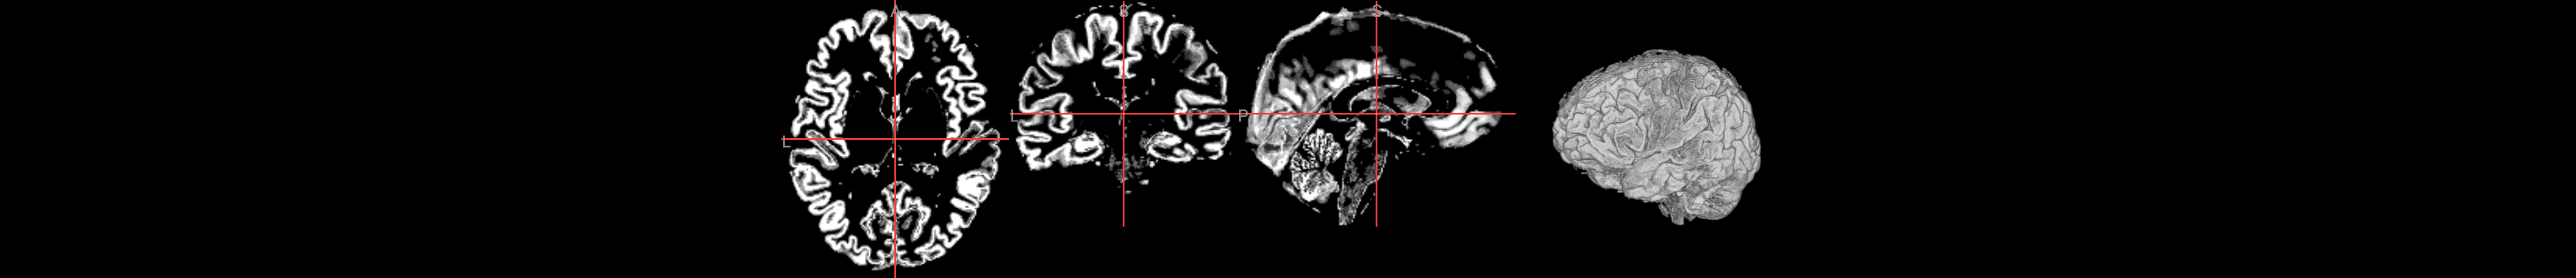

In [4]:
Image(filename='../../static/examples/diffusion_imaging/MRtrix_2/mrtrix_2_tissuetypes.png')

<div style="background-color: #f0f8ff; padding: 10px; border-radius: 5px;">
    <div style="background-color: #add8e6; padding: 5px; border-radius: 5px; font-weight: bold;">
        <span style="font-size: 15px; color: #add8e6; background-color: white; border-radius: 50%; width: 20px; height: 20px; display: inline-block; text-align: center; line-height: 20px;">
            !
        </span> <span style="color: white;">Note:</span>
    </div>
    <p style="margin: 10px 0;">
If the segmentation step fails, this may be due to insufficient contrast between the tissue types; for example, some anatomical images are either very dark across both the grey and white matter, or very light across both tissue types. We can help the segmentation process by increasing the intensity contrast (also known as intensity normalization) between the tissues with a command like AFNI’s 3dUnifize, e.g. </p>
        <code>3dUnifize -input anat.nii -prefix anat_unifize.nii</code> </p>
        The difference between the image before and after may be subtle, but it can prevent a segmentation error from being thrown.
    </p>
</div>

### Dependencies in Jupyter/Python
- Using the package [watermark](https://github.com/rasbt/watermark) to document system environment and software versions used in this notebook

In [25]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2025-11-06T22:43:21.260005+00:00

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.6.0

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 5.4.0-204-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

IPython   : 9.6.0
fury      : 0.11.0
nibabel   : 5.3.2
dipy      : 1.9.0
numpy     : 1.26.4
ipywidgets: 8.1.7
ipyniivue : 2.3.2
matplotlib: 3.10.7

